Resources:

1. [towards ds 10 min bin classifier](https://towardsdatascience.com/10-minutes-to-building-a-binary-image-classifier-by-applying-transfer-learning-to-mobilenet-eab5a8719525)
2. [tf tutorial on transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_dir = pathlib.Path(train_dir)
validation_dir = pathlib.Path(validation_dir)

In [7]:
list_train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
list_validation_ds = tf.data.Dataset.list_files(str(validation_dir/'*/*'))


def parse_image(fname):
    parts = tf.strings.split(fname, os.sep)
    class_label = parts[-2]
    prob_vec = tf.math.log([[0.25, 0.25, 0.25, 0.25]])
    rot_label = tf.random.categorical(prob_vec, 1, dtype=tf.int32)[0][0]
    image = tf.io.read_file(fname)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.rot90(image, k=rot_label, name=None)
    return image, rot_label

train_ds = list_train_ds.map(parse_image).batch(BATCH_SIZE)
validation_ds = list_validation_ds.map(parse_image).batch(BATCH_SIZE)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

hidden_layer = tf.keras.layers.Dense(10)
prediction_batch = hidden_layer(feature_batch_average)

prediction_layer = tf.keras.layers.Dense(4)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
Total params: 2,270,838
Trainable params: 12,854
Non-trainable params: 2,257,984
____________________________________________

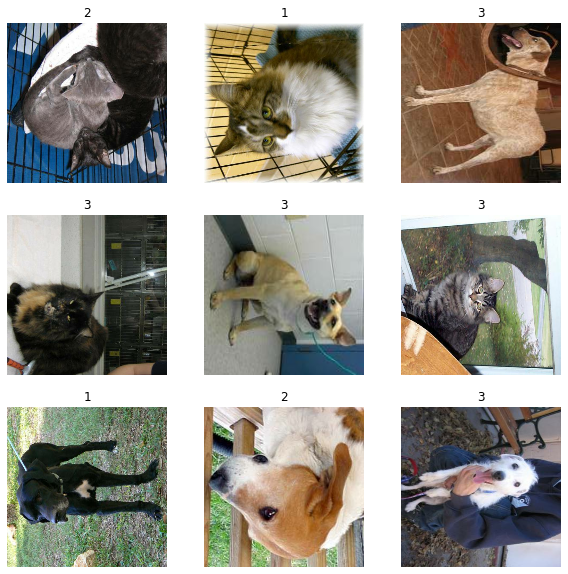

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i].numpy())
        plt.axis('off')


In [233]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [235]:
initial_epochs = 10

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
63/63 [==============================] - 42s 646ms/step - loss: 1.9786 - accuracy: 0.2290 - val_loss: 1.6056 - val_accuracy: 0.2900
Epoch 2/10
63/63 [==============================] - 43s 681ms/step - loss: 1.7292 - accuracy: 0.2971 - val_loss: 1.5090 - val_accuracy: 0.3350
Epoch 3/10
63/63 [==============================] - 43s 684ms/step - loss: 1.5237 - accuracy: 0.3515 - val_loss: 1.3539 - val_accuracy: 0.3730
Epoch 4/10
63/63 [==============================] - 53s 838ms/step - loss: 1.4572 - accuracy: 0.3831 - val_loss: 1.2688 - val_accuracy: 0.4310
Epoch 5/10
63/63 [==============================] - 60s 954ms/step - loss: 1.3418 - accuracy: 0.4058 - val_loss: 1.2183 - val_accuracy: 0.4680
Epoch 6/10
63/63 [==============================] - 43s 684ms/step - loss: 1.2866 - accuracy: 0.4561 - val_loss: 1.1443 - val_accuracy: 0.4970
Epoch 7/10
63/63 [==============================] - 57s 909ms/step - loss: 1.2530 - accuracy: 0.4543 - val_loss: 1.1309 - val_accuracy: 0.4990

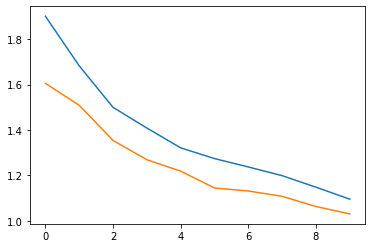

In [236]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

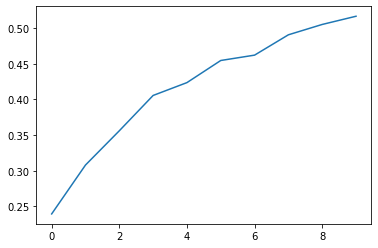

In [237]:
plt.plot(history.history['accuracy'])

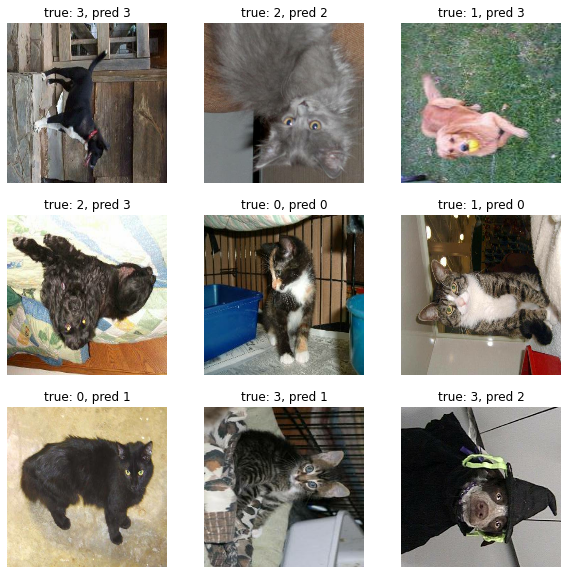

In [244]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    predictions = model.predict_on_batch(images)
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.math.argmax(predictions, axis=1)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'true: {labels[i].numpy()}, pred {predictions[i].numpy()}')
        plt.axis('off')
